# Import Libraries


In [1]:
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import IPython

In [3]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data


In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()


print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 1)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 1)


In [5]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [6]:
images = np.vstack([X_train, X_test])
labels = np.vstack([y_train, y_test])

print(f"images.shape = {images.shape}")
print(f"labels.shape = {labels.shape}")

print('class distribution')
pd.Series([class_names[i] for i in labels.flatten()]).value_counts()

images.shape = (60000, 32, 32, 3)
labels.shape = (60000, 1)
class distribution


frog          6000
truck         6000
deer          6000
automobile    6000
bird          6000
horse         6000
ship          6000
cat           6000
dog           6000
airplane      6000
dtype: int64

## Functions and Classes


In [7]:
from keras.utils import plot_model


In [8]:
# creates convolutional block
DOWNSAMPLE_COUNT = 0


def conv_block(
    filters,
    kernel_size=3,
    stride=2,
    padding="same",
    activation=keras.layers.LeakyReLU(alpha=0.2),
    use_bn=False,
    use_dropout=False,
    dropout_rate=0.4,
):
    global DOWNSAMPLE_COUNT

    model = keras.Sequential(name=f"downsample_conv_block_{DOWNSAMPLE_COUNT}")
    if use_bn:
        model.add(keras.layers.BatchNormalization())
    if use_dropout:
        model.add(keras.layers.Dropout(dropout_rate))

    model.add(
        keras.layers.Conv2D(
            filters,
            kernel_size=kernel_size,
            strides=stride,
            padding=padding,
            activation=activation,
        )
    )

    DOWNSAMPLE_COUNT += 1
    return model

In [9]:
# creates upsample and convolutional block
UPSAMPLE_COUNT = 0


def conv_upsample_block(
    filters,
    kernel_size=3,
    padding="same",
    activation=keras.layers.LeakyReLU(alpha=0.2),
    use_bn=False,
    use_dropout=False,
    dropout_rate=0.4,
):
    global UPSAMPLE_COUNT

    model = keras.Sequential(name=f"upsample_conv_block_{UPSAMPLE_COUNT}")
    if use_bn:
        model.add(keras.layers.BatchNormalization())
    if use_dropout:
        model.add(keras.layers.Dropout(dropout_rate))
    
    model.add(keras.layers.UpSampling2D())
    model.add(
        keras.layers.Conv2D(
            filters,
            kernel_size=kernel_size,
            padding=padding,
            activation=activation,
        )
    )

    UPSAMPLE_COUNT += 1
    return model

In [10]:
# creates transposed concolutional block
TRANSPOSE_COUNT = 0


def conv_transpose_block(
    filters,
    kernel_size=3,
    stride=2,
    padding="same",
    activation=keras.layers.LeakyReLU(alpha=0.2),
    use_bn=False,
    use_dropout=False,
    dropout_rate=0.4,
):
    global TRANSPOSE_COUNT

    model = keras.Sequential(name=f"transpose_conv_block_{TRANSPOSE_COUNT}")
    if use_bn:
        model.add(keras.layers.BatchNormalization())
    if use_dropout:
        model.add(keras.layers.Dropout(dropout_rate))

    model.add(
        keras.layers.Conv2DTranspose(
            filters,
            kernel_size=kernel_size,
            strides=stride,
            padding=padding,
            activation=activation,
        )
    )

    TRANSPOSE_COUNT += 1
    return model

In [11]:
# base GAN class
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(
        self,
        d_optimizer,
        g_optimizer,
        loss_fn,
        metrics=["accuracy"],
    ):
        super(GAN, self).compile()
        self.discriminator.compile(optimizer=d_optimizer, loss=loss_fn, metrics=metrics)
        self.generator.compile(optimizer=g_optimizer, loss=loss_fn)

    def call(self, input, training=False):
        image = self.generator(input)
        score = self.discriminator(image)

        return image, score

In [12]:
from wandb.keras import WandbModelCheckpoint, WandbMetricsLogger, WandbCallback

In [13]:
# Wandb epoch model saver
# Referenced from official WandBModelCheckpoint docs:
# https://github.com/wandb/wandb/blob/latest/wandb/integration/keras/callbacks/model_checkpoint.py#L123

import glob
import os
import string
import sys

class WandbEpochModelCheckpoint(keras.callbacks.ModelCheckpoint):
    def __init__(self,
                 filepath,
                 frequency=1,
                 monitor='val_loss',
                 verbose=0,
                 save_best_only=False,
                 save_weights_only=False,
                 mode='auto',
                 options=None,
                 **kwargs):

        super().__init__(
            filepath=filepath,
            monitor=monitor,
            verbose=verbose,
            save_best_only=save_best_only,
            save_weights_only=save_weights_only,
            mode=mode,
            save_freq='epoch',
            options=options,
            **kwargs,
        )
        self.epochs_since_last_save = 0
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:
            self._save_model(epoch=epoch, batch=None, logs=logs)
 
            super().on_epoch_end(epoch, logs)

            # Get filepath where the model checkpoint is saved.
            filepath = self._get_file_path(epoch=epoch, batch=None, logs=logs)
            # Log the model as artifact
            aliases = ["latest", f"epoch_{epoch}"]
            self._log_ckpt_as_artifact(filepath, aliases=aliases)

    def on_train_batch_end(self, batch, logs=None):
        pass

    #========================================

    def _log_ckpt_as_artifact(
        self, filepath, aliases
    ) -> None:
        """Log model checkpoint as  W&B Artifact."""
        try:
            assert wandb.run is not None
            model_artifact = wandb.Artifact(f"run_{wandb.run.id}_model", type="model")
            if self.save_weights_only:
                # We get three files when this is True
                model_artifact.add_file(
                    os.path.join(os.path.dirname(filepath), "checkpoint")
                )
                model_artifact.add_file(filepath + ".index")
                # In a distributed setting we get multiple shards.
                for file in glob.glob(f"{filepath}.data-*"):
                    model_artifact.add_file(file)
            elif filepath.endswith(".h5"):
                # Model saved in .h5 format thus we get one file.
                model_artifact.add_file(filepath)
            else:
                # Model saved in the SavedModel format thus we have dir.
                model_artifact.add_dir(filepath)
            wandb.log_artifact(model_artifact, aliases=aliases or [])
        except ValueError:
            # This error occurs when `save_best_only=True` and the model
            # checkpoint is not saved for that epoch/batch. Since TF/Keras
            # is giving friendly log, we can avoid clustering the stdout.
            pass

    def _check_filepath(self):
        placeholders = []
        for tup in string.Formatter().parse(self.filepath):
            if tup[1] is not None:
                placeholders.append(tup[1])
        if len(placeholders) == 0:
            wandb.termwarn(
                "When using `save_best_only`, ensure that the `filepath` argument "
                "contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. "
                "This ensures correct interpretation of the logged artifacts.",
                repeat=False,
            )

In [14]:
# Log generator images
class GeneratorImageLogger(keras.callbacks.Callback):
    def __init__(self, latent_dim, log_freq=5, subplot_rows=10, logdir=None):
        super(GeneratorImageLogger, self).__init__()
        self.logdir = logdir
        self.log_freq = log_freq
        self.subplot_rows = subplot_rows
        self.latent_dim = latent_dim

    def _generate_img_subplot(self, images):
        no_of_cols = int(len(images) / self.subplot_rows)

        fig = plt.figure(figsize=(2 * no_of_cols, 2 * self.subplot_rows))
        for i in range(len(images)):
            ax = fig.add_subplot(self.subplot_rows, no_of_cols, i + 1)
            ax.imshow(images[i])
            ax.grid(False)
            ax.axis(False)
            ax.set_aspect("equal")

        fig.subplots_adjust(wspace=0, hspace=0)
        return fig

    def on_train_begin(self, logs=None):
        if self.logdir is not None:
            os.makedirs(self.logdir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.log_freq != 0:
            return

        latent_vectors = tf.random.normal((self.subplot_rows**2, self.latent_dim))
        generated_images = self.model.generator(latent_vectors)
        fig = self._generate_img_subplot(generated_images)

        wandb.log({"g_images": fig}, step=epoch)
        if self.logdir is not None:
            plt.savefig(f"{self.logdir}/epoch_{epoch}")
        plt.close(fig)

# $ $

## Functions and Classes

In [89]:
# custom ss_infoGAN with q in training loop


class ss_infoGAN(GAN):
    def __init__(
        self,
        discriminator,
        generator,
        q,
        latent_dim,
        supervised_categorical=None,
        categorical_control=None,
        continuous_control=None,
    ):
        """
        supervised_categorical :: number of classes in one-hot vector
        categorical_control :: list of number of classes in one-hot vector
        continous_control :: tuple corresponding to
                            range of uniform distribution for code, i.e. (-1, 1)

        currently only multiple unsupervised categorical codes are implemented

        outputs of q must be ordered as
        [
            supervised cat_code,
            unsupervised cat_code1,
            unsupervised cat_code2,
            ...,
            unsupervised cont_code
        ]
        and inputs of generator must be ordered as
        [
            latent,
            supervised cat_code,
            unsupervised cat_code1,
            unsupervised cat_code2,
            ...,
            unsupervised cont_code
        ]
        """
        super(ss_infoGAN, self).__init__(discriminator, generator, latent_dim)

        self.q = q
        self.supervised_categorical = supervised_categorical
        self.categorical_control = categorical_control or []
        self.continuous_control = continuous_control

    def compile(
        self,
        d_optimizer,
        g_optimizer,
        d_loss_fn,
        g_loss_fn,
        q_cat_loss_fn=None,
        q_cont_loss_fn=None,
        metrics=["accuracy"],
    ):
        super(GAN, self).compile()
        self.discriminator.compile(
            optimizer=d_optimizer, loss=d_loss_fn, metrics=metrics
        )
        self.generator.compile(optimizer=g_optimizer, loss=g_loss_fn)
        self.q.compile(optimizer=d_optimizer)
        self.q_cat_loss = q_cat_loss_fn
        self.q_cont_loss = q_cont_loss_fn

    def _varied_continuous_codes(self, no_of_samples, lower, upper):
        return tf.reshape(tf.linspace(lower, upper, 10), (-1, 1))

    def _random_continuous_codes(self, no_of_samples, lower, upper):
        return tf.reshape(
            tf.random.uniform(
                shape=(no_of_samples,),
                minval=upper,
                maxval=lower,
            ),
            (-1, 1),
        )

    def _varied_categorical_codes(self, no_of_samples, code_size):
        return tf.one_hot(indices=tf.range(no_of_samples), depth=code_size)

    def _random_categorical_codes(self, no_of_samples, code_size):
        random_indices = tf.random.uniform(
            shape=(no_of_samples,), minval=0, maxval=code_size, dtype=tf.int32
        )
        return tf.one_hot(indices=random_indices, depth=code_size)

    def _generator_inputs(self, batch_size):
        inputs = []
        latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        inputs.append(latent_vectors)
        # generate supervised categoricals
        supervised_categoricals = self._random_categorical_codes(
            batch_size, self.supervised_categorical
        )
        inputs.append(supervised_categoricals)
        # generate unsupervised categoricals
        if len(self.categorical_control) != 0:
            for code_size in self.categorical_control:
                cat_codes = self._random_categorical_codes(batch_size, code_size)
                inputs.append(cat_codes)
        # generate unsupervised continuous
        if self.continuous_control is not None:
            lower, upper = self.continuous_control
            cont_codes = self._random_continuous_codes(batch_size, lower, upper)
            inputs.append(cont_codes)

        return inputs

    def train_step(self, data):
        real_images, real_classes = data
        if isinstance(real_images, tuple):
            real_images = real_images
        real_classes = tf.reshape(tf.one_hot(real_classes, depth=10), shape=(-1, 10))
        batch_size = tf.shape(real_images)[0]

        # ==================================
        # Train discriminator and q on real
        # ==================================
        real_images = real_images / 255
        real_labels = tf.fill((batch_size, 1), 0.9)
        with tf.GradientTape() as d_tape, tf.GradientTape() as q_tape:
            real_predictions = self.discriminator(real_images)
            d_real_loss = self.discriminator.compiled_loss(
                real_labels,
                real_predictions,
            )
            real_q = self.q(real_images)
            q_real_loss = self.q_cat_loss(real_classes, real_q)

        # ===== Gradient descent =======
        d_real_grads = d_tape.gradient(
            d_real_loss, self.discriminator.trainable_weights
        )
        self.discriminator.optimizer.apply_gradients(
            zip(d_real_grads, self.discriminator.trainable_weights)
        )
        q_real_grads = q_tape.gradient(q_real_loss, self.q.trainable_weights)
        self.q.optimizer.apply_gradients(zip(q_real_grads, self.q.trainable_weights))

        # ==================================
        # Train discriminator and q on fake
        # ==================================
        g_inputs = self._generator_inputs(batch_size)
        fake_images = self.generator(g_inputs)
        fake_labels = tf.fill((batch_size, 1), 0.1)

        with tf.GradientTape() as d_tape, tf.GradientTape() as q_tape:
            fake_predictions = self.discriminator(fake_images)
            d_fake_loss = self.discriminator.compiled_loss(
                fake_labels, fake_predictions
            )
            q_fake_loss = 0
            fake_q_predictions = self.q(fake_images)
            fake_supervised_categorical = fake_q_predictions
            q_fake_loss += self.q_cat_loss(g_inputs[1], fake_supervised_categorical)

            if len(self.categorical_control) != 0:
                fake_cat_codes = fake_q_predictions[
                    1 : len(self.categorical_control) + 1
                ]
                q_fake_loss += self.q_cat_loss(
                    g_inputs[2 : len(self.categorical_control) + 2], fake_cat_codes
                )
            if self.continuous_control is not None:
                fake_cont_codes = fake_q_predictions[-1]
                q_fake_loss += self.q_cont_loss(g_inputs[-1], fake_cont_codes)

        # ===== Gradient descent =======
        d_fake_grads = d_tape.gradient(
            d_fake_loss, self.discriminator.trainable_weights
        )
        self.discriminator.optimizer.apply_gradients(
            zip(d_fake_grads, self.discriminator.trainable_weights)
        )
        q_fake_grads = q_tape.gradient(q_fake_loss, self.q.trainable_weights)
        self.q.optimizer.apply_gradients(zip(q_fake_grads, self.q.trainable_weights))

        # ==================================
        # Train the generator
        # ==================================
        g_inputs = self._generator_inputs(2 * batch_size)
        misleading_labels = tf.fill((2 * batch_size, 1), 0.9)

        with tf.GradientTape() as tape:
            fake_images = self.generator(g_inputs)
            misleading_predictions = self.discriminator(fake_images)
            g_d_loss = self.generator.compiled_loss(
                misleading_labels, misleading_predictions
            )

            g_q_fake_loss = 0
            misleading_q_predictions = self.q(fake_images)
            g_fake_supervised_categorical = misleading_q_predictions
            g_q_fake_loss += self.q_cat_loss(g_inputs[1], g_fake_supervised_categorical)
            if len(self.categorical_control) != 0:
                g_fake_cat_codes = misleading_q_predictions[
                    1 : len(self.categorical_control) + 1
                ]
                g_q_fake_loss += self.q_cat_loss(
                    g_inputs[2 : len(self.categorical_control) + 2], g_fake_cat_codes
                )
            if self.continuous_control is not None:
                g_fake_cont_codes = misleading_q_predictions[-1]
                g_q_fake_loss += self.q_cont_loss(g_inputs[-1], g_fake_cont_codes)

            g_loss = g_q_fake_loss + g_d_loss

        # ===== Gradient descent =======
        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator.optimizer.apply_gradients(
            zip(g_grads, self.generator.trainable_weights)
        )

        log_metrics = {
            "d_loss": d_real_loss + d_fake_loss,
            "q_loss": q_fake_loss + q_fake_loss,
            "g_loss": g_loss,
        }
        return log_metrics

In [70]:
# plot images with varied codes and constant noise
class infoGANImageLogger(GeneratorImageLogger):
    def __init__(self, latent_dim, log_freq=5, subplot_rows=5, logdir=None):
        super(infoGANImageLogger, self).__init__(
            latent_dim, log_freq, subplot_rows, logdir
        )

    """
    to evaluate the codes, they have to be varied along an axis 
    while all other inputs remain the same. Therefore, the inputs should be
    [
        [latent1, code1, constant other codes],
        [latent1, code2, constant other codes],
        [latent1, code3, constant other codes],
        ..., ..., ..., ...,
        [latent1, code_n, constant other codes],

        [latent2, code1, constant other codes],
        [latent2, code2, constant other codes],
        [latent2, code3, constant other codes],
        ..., ..., ..., ...,
        [latent2, code_n, constant other codes],
        ..., ..., ..., ...,
        ..., ..., ..., ...,

        [latent_m, code1, constant other codes],
        [latent_m, code2, constant other codes],
        [latent_m, code3, constant other codes],
        ..., ..., ..., ...,
        [latent_m, code_n, constant other codes]
    ]   

    tf.tile can handle what the code1 to code_n needs to look like
    tf.repeat can handle what the latent1 to latent_m needs to look like
    """

    def latent_categorical_pairs(self, latent, code_size):
        cat_code = self.model._varied_categorical_codes(code_size, code_size)
        multiples = [len(latent), 1]
        codes = tf.tile(cat_code, multiples=multiples)

        repeats = tf.fill((len(latent)), code_size)
        noise = tf.repeat(latent, repeats=repeats, axis=0)

        return noise, codes

    def latent_continuous_pairs(self, latent, lower, upper):
        cont_code = self.model._varied_continuous_codes(10, lower, upper)
        multiples = [len(latent), 1]
        codes = tf.tile(cont_code, multiples=multiples)

        repeats = tf.fill((len(latent)), 10)
        noise = tf.repeat(latent, repeats=repeats, axis=0)

        return noise, codes

    def on_train_begin(self, logs=None):
        try:  # handle attribute differences between infoGan and ss infoGan
            categoricals = [
                self.model.supervised_categorical,
                *self.model.categorical_control,
            ]
        except AttributeError:
            categoricals = self.model.categorical_controls

        if self.logdir is not None:
            if len(categoricals):
                for i in range(len(categoricals)):
                    os.makedirs(f"{self.logdir}/categorical_{i}", exist_ok=True)

            if self.model.continuous_control is not None:
                os.makedirs(f"{self.logdir}/continuous", exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.log_freq != 0:
            return

        latent = tf.random.normal(shape=(self.subplot_rows, self.latent_dim))

        try:  # handle attribute differences between infoGan and ss infoGan
            categoricals = [
                self.model.supervised_categorical,
                *self.model.categorical_control,
            ]
        except AttributeError:
            categoricals = self.model.categorical_controls

        # evaluate categorical
        if len(categoricals) != 0:
            # for each code
            for i, code_size in enumerate(categoricals):
                one_hots = [  # generate list of constant onehot for all codes
                    tf.repeat(
                        tf.one_hot(
                            indices=[0],
                            depth=control,
                        ),
                        repeats=code_size * self.subplot_rows,
                        axis=0,
                    )
                    for control in categoricals
                ]
                noise, codes = self.latent_categorical_pairs(latent, code_size)
                # overwrite constant onehot with varied
                one_hots[i] = codes
                inputs = [noise, *one_hots]

                if self.model.continuous_control is not None:
                    cont = tf.zeros(shape=(code_size * self.subplot_rows))
                    inputs.append(cont)

                cat_fig = self._generate_img_subplot(self.model.generator(inputs))

                wandb.log({f"categorical_{i}": cat_fig}, step=epoch)
                if self.logdir is not None:
                    plt.savefig(f"{self.logdir}/categorical_{i}/epoch_{epoch}")
                plt.close(cat_fig)

        # evaluate continuous
        if self.model.continuous_control is not None:
            lower, upper = self.model.continuous_control
            noise, cont = self.latent_continuous_pairs(latent, lower, upper)

            if len(categoricals) != 0:
                one_hots = [  # generate list of constant onehot for all codes
                    tf.repeat(
                        tf.one_hot(
                            indices=[0],
                            depth=control,
                        ),
                        repeats=10 * self.subplot_rows,
                        axis=0,
                    )
                    for control in categoricals
                ]

            inputs = [noise, *one_hots, cont]
            cont_fig = self._generate_img_subplot(self.model.generator(inputs))

            wandb.log({"continuous_code": cont_fig}, step=epoch)
            if self.logdir is not None:
                plt.savefig(f"{self.logdir}/continuous/epoch_{epoch}")
            plt.close(cont_fig)

### Setup

In [17]:
EPOCHS_TRAINED = 0
group = "ss_infoGAN"

In [18]:
model_name = "one_cat_infogan"

In [19]:
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

In [20]:
wandb.init(
    project="cifar10_gan",
    name=f"{model_name}_{now}",
    config=dict(
        architecture="infogan",
        latent_dim=128,
        disc_layers=["3x3x64", "3x3x64_1", "3x3x128", "3x3x128_1", "FC100"],
        gen_layers=["FC4*4*72","3x3x128", "3x3x64", "3x3x64_1", "3x3x32"],
        control={"categorical": [10], "continuous":None},
    ),
    group=group,
)
# key 1b33553de266344186f717f703fad4a31800e0b3

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bevanpoh. Use `wandb login --relogin` to force relogin


### Architecture

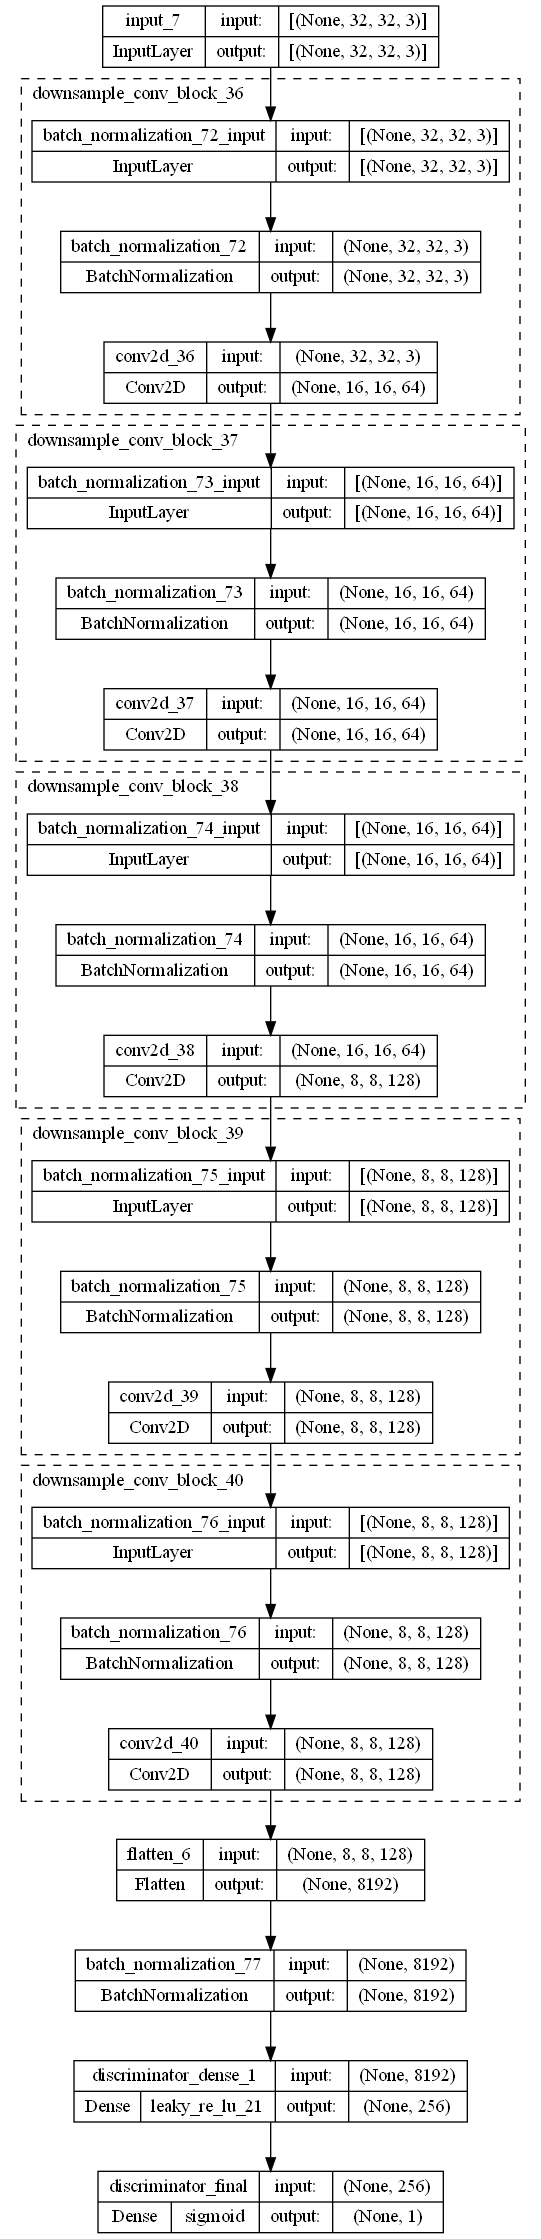

In [90]:
d_in = (keras.Input(shape=(32, 32, 3)))

d_conv = conv_block(64, use_bn=True)(d_in)
d_conv = conv_block(64, stride=1, use_bn=True)(d_conv)
d_conv = conv_block(128, use_bn=True)(d_conv)
d_conv = conv_block(128, stride=1, use_bn=True)(d_conv)
d_conv = conv_block(128, stride=1, use_bn=True)(d_conv)
d_flat = keras.layers.Flatten()(d_conv)

d_dense = keras.layers.BatchNormalization()(d_flat)
d_dense = (
    keras.layers.Dense(
        256, activation=keras.layers.LeakyReLU(alpha=0.1), name="discriminator_dense_1"
    )
)(d_dense)

d_out = keras.layers.Dense(1, activation="sigmoid", name="discriminator_final")(d_dense)

discriminator = keras.Model(inputs=d_in, outputs=d_out, name="discriminator")
plot_model(discriminator, show_shapes=True, show_layer_activations=True, expand_nested=True)

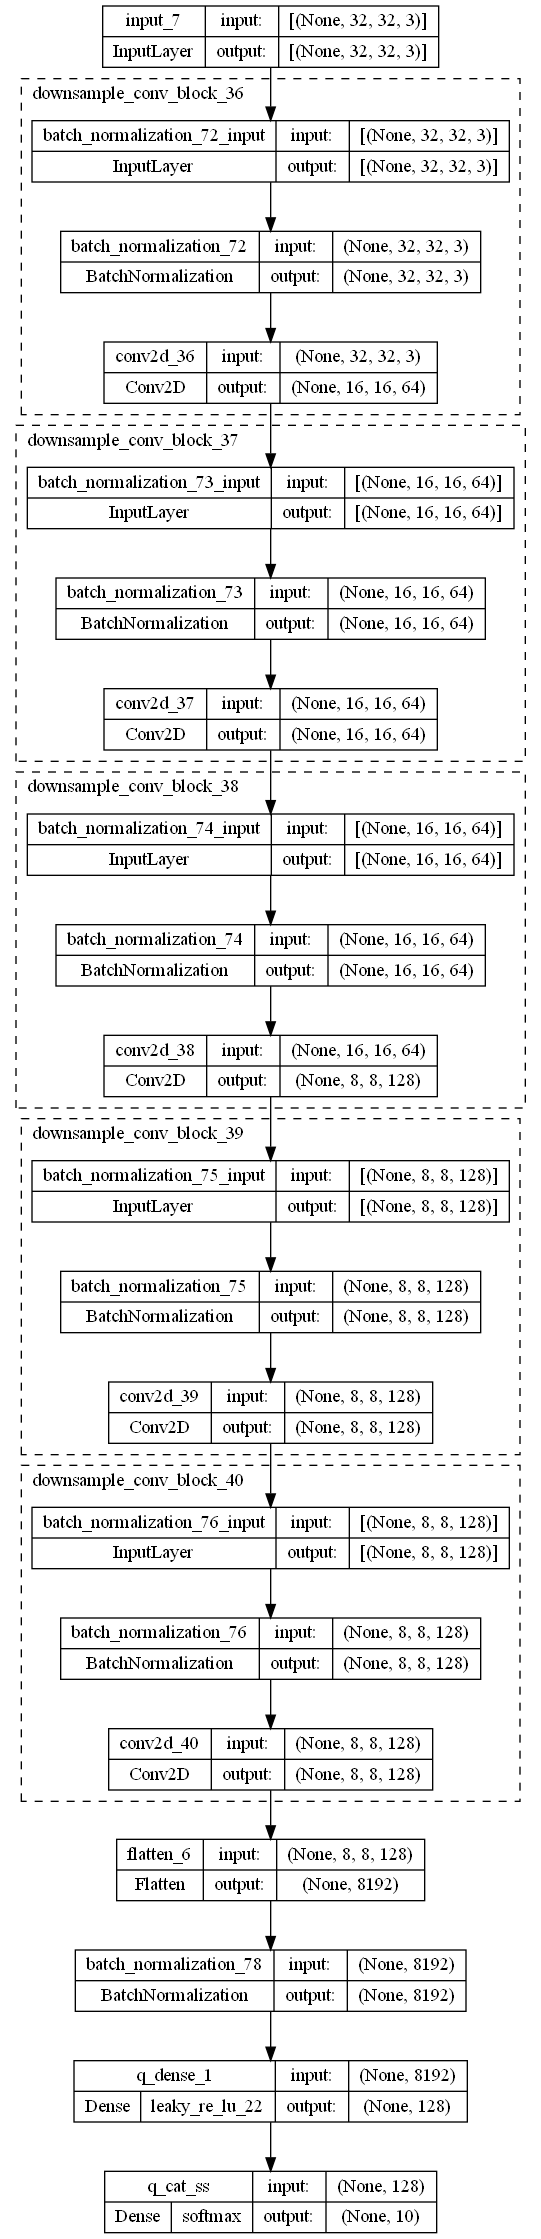

In [91]:
q_out = keras.layers.BatchNormalization()(d_flat)
q_out = keras.layers.Dense(
    128, activation=keras.layers.LeakyReLU(alpha=0.1), name="q_dense_1"
)(q_out)

q_cat_ss = keras.layers.Dense(10, activation="softmax", name="q_cat_ss")(q_out)

q = keras.Model(inputs=d_in, outputs=[q_cat_ss], name="q")
plot_model(q, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [92]:
q.summary(expand_nested=True)

# 1.49 mil params

Model: "q"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 downsample_conv_block_36 (S  (None, 16, 16, 64)       1804      
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| batch_normalization_72 (Bat  (None, 32, 32, 3)      12        |
| chNormalization)                                              |
|                                                               |
| conv2d_36 (Conv2D)        (None, 16, 16, 64)        1792      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 downsample_conv_block_37 (S  (None, 16, 16, 64)       37184     
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|

In [93]:
discriminator.summary(expand_nested=True)

# 2.3mil params

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 downsample_conv_block_36 (S  (None, 16, 16, 64)       1804      
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| batch_normalization_72 (Bat  (None, 32, 32, 3)      12        |
| chNormalization)                                              |
|                                                               |
| conv2d_36 (Conv2D)        (None, 16, 16, 64)        1792      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 downsample_conv_block_37 (S  (None, 16, 16, 64)       37184     
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

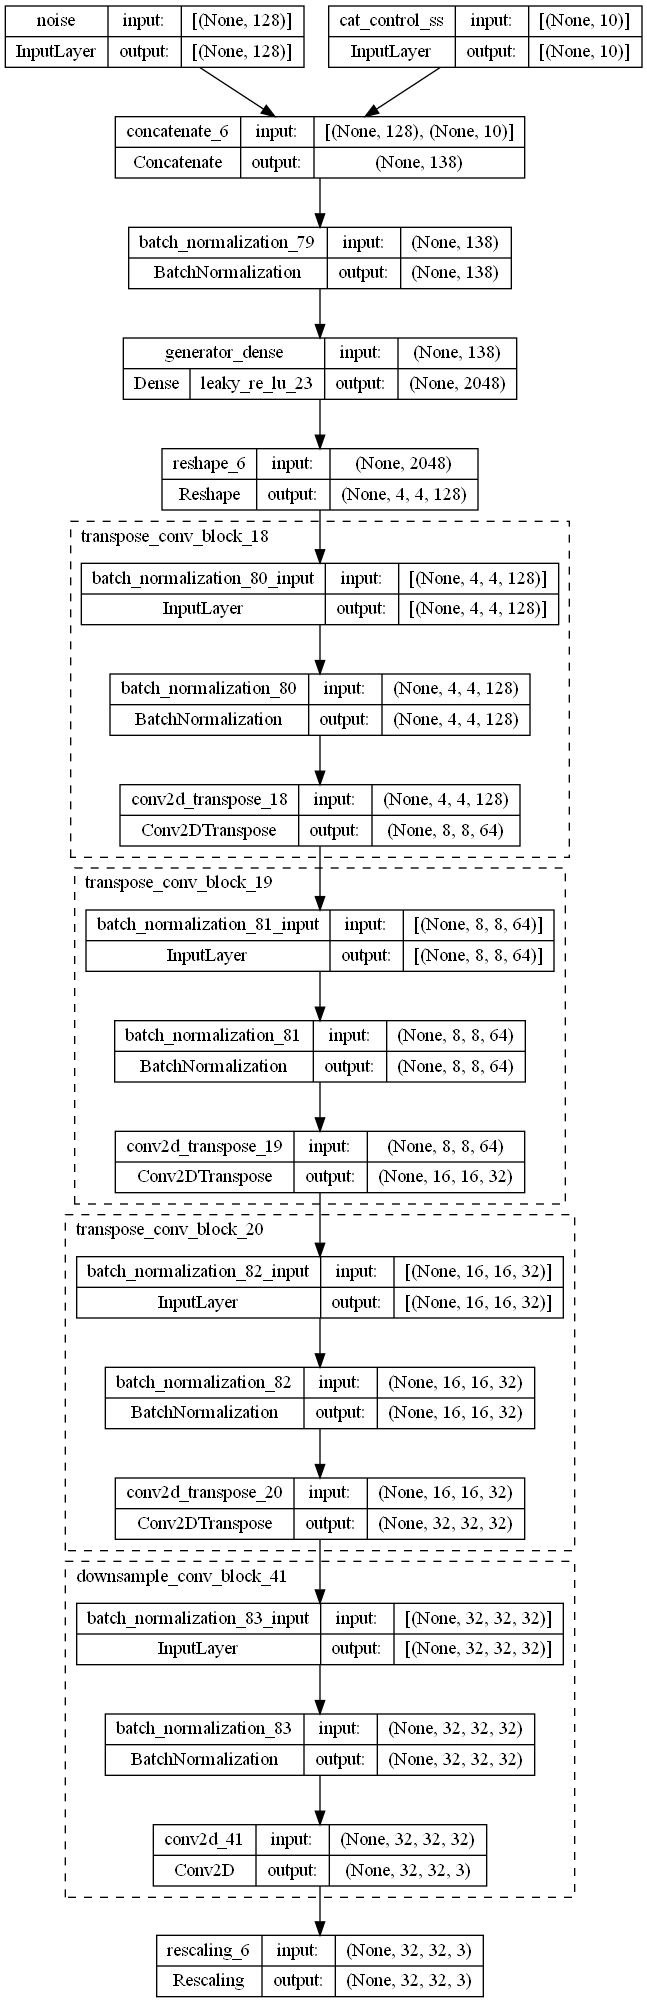

In [94]:
g_noise = keras.Input(shape=(128,), name="noise")
g_cat_ss = keras.Input(shape=(10,), name="cat_control_ss")

concat_layer = keras.layers.Concatenate(axis=-1)([g_noise, g_cat_ss])

g_dense = keras.layers.BatchNormalization()(concat_layer)
g_dense = (
    keras.layers.Dense(
        4 * 4 * 128,
        activation=keras.layers.LeakyReLU(alpha=0.1),
        name="generator_dense",
    )
)(g_dense)
g_conv = keras.layers.Reshape((4, 4, 128))(g_dense)

g_conv = conv_transpose_block(64, use_bn=True)(g_conv)
g_conv = conv_transpose_block(32, use_bn=True)(g_conv)
g_conv = conv_transpose_block(32, use_bn=True)(g_conv)
g_conv = conv_block(3, stride=1, activation="tanh", use_bn=True)(g_conv)

# output range 0 to 1
g_out = keras.layers.Rescaling(scale=0.5, offset=0.5)(g_conv)

generator = keras.Model(
    inputs=[g_noise, g_cat_ss], outputs=g_out, name="generator"
)

plot_model(generator, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [95]:
generator.summary(expand_nested=True)

# 388k params

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 cat_control_ss (InputLayer)    [(None, 10)]         0           []                               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 138)          0           ['noise[0][0]',                  
                                                                  'cat_control_ss[0][0]']         
                                                                                                  
 batch_normalization_79 (BatchN  (None, 138)         552         ['concatenate_6[0][0]']  

1/1 [==============================] - 0s 142ms/step
Discriminator score: [0.52210945]


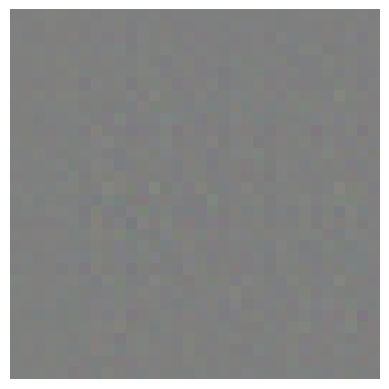

In [96]:
ss_infogan = ss_infoGAN(
    discriminator=discriminator,
    generator=generator,
    q=q,
    latent_dim=128,
    supervised_categorical=10,
)
ss_infogan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=2 * 10**-4),
    g_optimizer=keras.optimizers.Adam(learning_rate=1 * 10**-3),
    d_loss_fn=keras.losses.BinaryCrossentropy(),
    g_loss_fn=keras.losses.BinaryCrossentropy(),
    q_cat_loss_fn=keras.losses.CategoricalCrossentropy(),
    q_cont_loss_fn=keras.losses.MeanSquaredError(),
)

# ss_infogan.load_weights("../chkpts/ss_infogan/005")

random_vector = tf.random.normal(shape=(1, 128))
random_onehot1 = tf.one_hot(
    tf.random.uniform(shape=(1,), minval=0, maxval=10, dtype=tf.int32), 10
)
generated_image = ss_infogan.generator.predict(
    [random_vector, random_onehot1]
)
discriminator_score = ss_infogan.discriminator.predict(generated_image)
print("Discriminator score:", discriminator_score[0])
plt.imshow(generated_image[0])
plt.grid(False)
plt.axis(False)
plt.show()

### Training

In [102]:
BATCH_SIZE = 150
EPOCHS = 7

EPOCHS_TRAINED = 13

In [ ]:
history = ss_infogan.fit(
    images,
    labels,
    epochs=EPOCHS_TRAINED + EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        infoGANImageLogger(
            logdir=f"../images/{model_name}/",
            latent_dim=wandb.config.latent_dim,
            log_freq=1,
            subplot_rows=10,
        ),
        WandbMetricsLogger(),
        WandbEpochModelCheckpoint(
            filepath=f"../chkpts/{model_name}/" + "{epoch:03d}",
            frequency=5,
            save_weights_only=True,
        ),
        keras.callbacks.CSVLogger(
            f"../histories/{model_name}.csv", append=bool(EPOCHS_TRAINED)
        ),
    ],
    initial_epoch=EPOCHS_TRAINED,
)

history_df = pd.read_csv(f"../histories/{model_name}.csv")

EPOCHS_TRAINED = len(history_df)
EPOCHS_TRAINED

In [36]:
wandb.finish()

epoch/d_loss,▄█▃▃▂▃▂▂▂▂▁▁▃▃▂▂▂▅▂▂▃▃▂▃▃▄▃▃▄▂▂▂▃▃▃
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/g_loss,▂▁▄▃▅▃▄▃▃▃▃▃▅█▄▃▃▂▃▄▄▃▄▃▄▂▃▄▁▄▃▃▄▃▄
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/q_loss,▇▄▆▅▃▂▂▂▁▁▂▁▂▃▁▂▁▆▁▁▁▁▂▁▂▄▂█▁▂▁▁▁▁▁
epoch/d_loss,0.69576
epoch/epoch,34
epoch/g_loss,2.32476
epoch/learning_rate,0.001
epoch/q_loss,0.01838
